In [1]:
import argparse
import time
import sys, os
import pickle
import seaborn as sns
import torch
import scvelo as scv
import scanpy
import scipy
import numpy as np
import seaborn as sns
import pandas as pd

from veloproj import *
from veloproj.model import leastsq_pt
from sklearn.decomposition import PCA
from IPython import display
from matplotlib import pyplot as plt

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-5',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/groups/yhhuang/cqiao/Melania/adata_human_def.h5',
                               '--model-name', 'Melania_Erythroid_human_model.cpt',
                               '--exp-name', 'CohAE_Melania_Erythroid_human',
                               '--device', 'cuda:0',
                               '--gumbsoft_tau', '1',
                               '--nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("Early Erythroid", "Mid  Erythroid"), ('Mid  Erythroid', "Late Erythroid")]
k_cluster = "type2"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
par_path = "/data/users/cqiao/notebooks/projects/PaperRev/VeloRep2/notebooks/Melania_human/"
fast_data_path = "data.h5ad"
if fast_data_path in os.listdir(par_path):
    adata = scanpy.read_h5ad(os.path.join(par_path, fast_data_path))
else:
    adata = scanpy.read_h5ad(args.data_dir)
    sel = np.zeros(adata.n_obs, dtype=np.bool)
    sel = sel | (adata.obs.celltype == "Erythroid1").values | (adata.obs.celltype == "Erythroid2").values | (adata.obs.celltype == "Erythroid3").values
    sel = sel | (adata.obs.celltype == "Blood progenitors 1").values | sel | (adata.obs.celltype == "Blood progenitors 2").values
    adata = adata[sel]
    scv.utils.show_proportions(adata)
    scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
    scv.tl.velocity_graph(adata, vkey='stc_velocity')
    scv.tl.velocity_confidence(adata, vkey='stc_velocity')

print(adata)


AnnData object with n_obs × n_vars = 35877 × 2000
    obs: 'Clusters', '_X', '_Y', 'batch', 'type', 'samp', 'leiden', 'type2', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'stc_velocity_length', 'stc_velocity_confidence', 'stc_velocity_confidence_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'stc_velocity_gamma', 'stc_velocity_r2', 'stc_velocity_genes'
    uns: 'leiden', 'neighbors', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'stc_velocity_params', 'type2_colors'
    obsm: 'X_pca', 'X_umap', 'stc_velocity_umap'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'stc_velocity', 'unspliced', 'variance_stc_velocity'
    obsp: 'connectivities', 'distances'


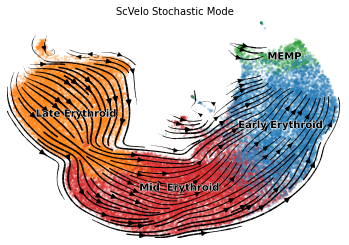

# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.081447646, ('Mid  Erythroid', 'Late Erythroid'): 0.04631139}
Total Mean: 0.06387951970100403
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.7524644, ('Mid  Erythroid', 'Late Erythroid'): 0.8911031}
Total Mean: 0.8217837810516357
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): -0.3915759926120027, ('Mid  Erythroid', 'Late Erythroid'): -0.659077433493216}
Total Mean: -0.5253267130526094
# In-cluster Coherence
{'Early Erythroid': 0.84404796, 'Late Erythroid': 0.93301064, 'MEMP': 0.94228786, 'Mid  Erythroid': 0.85356015}
Total Mean: 0.893226683139801
# In-cluster Confidence
{'Early Erythroid': 0.8211951176751143, 'Late Erythroid': 0.9371989427152257, 'MEMP': 0.9497227164934267, 'Mid  Erythroid': 0.8122398725342098}
Total Mean: 0.8800891623544941


In [6]:
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=k_cluster,
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity", x_emb="X_umap")

recovering dynamics (using 10/40 cores)


  0%|          | 0/2000 [00:00<?, ?gene/s]

    finished (0:18:08) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:01:13) --> added 
    'dyn_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:02:06) --> added 
    'dyn_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:10) --> added
    'dyn_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_Melania_Erythroid_human_dynamical.png


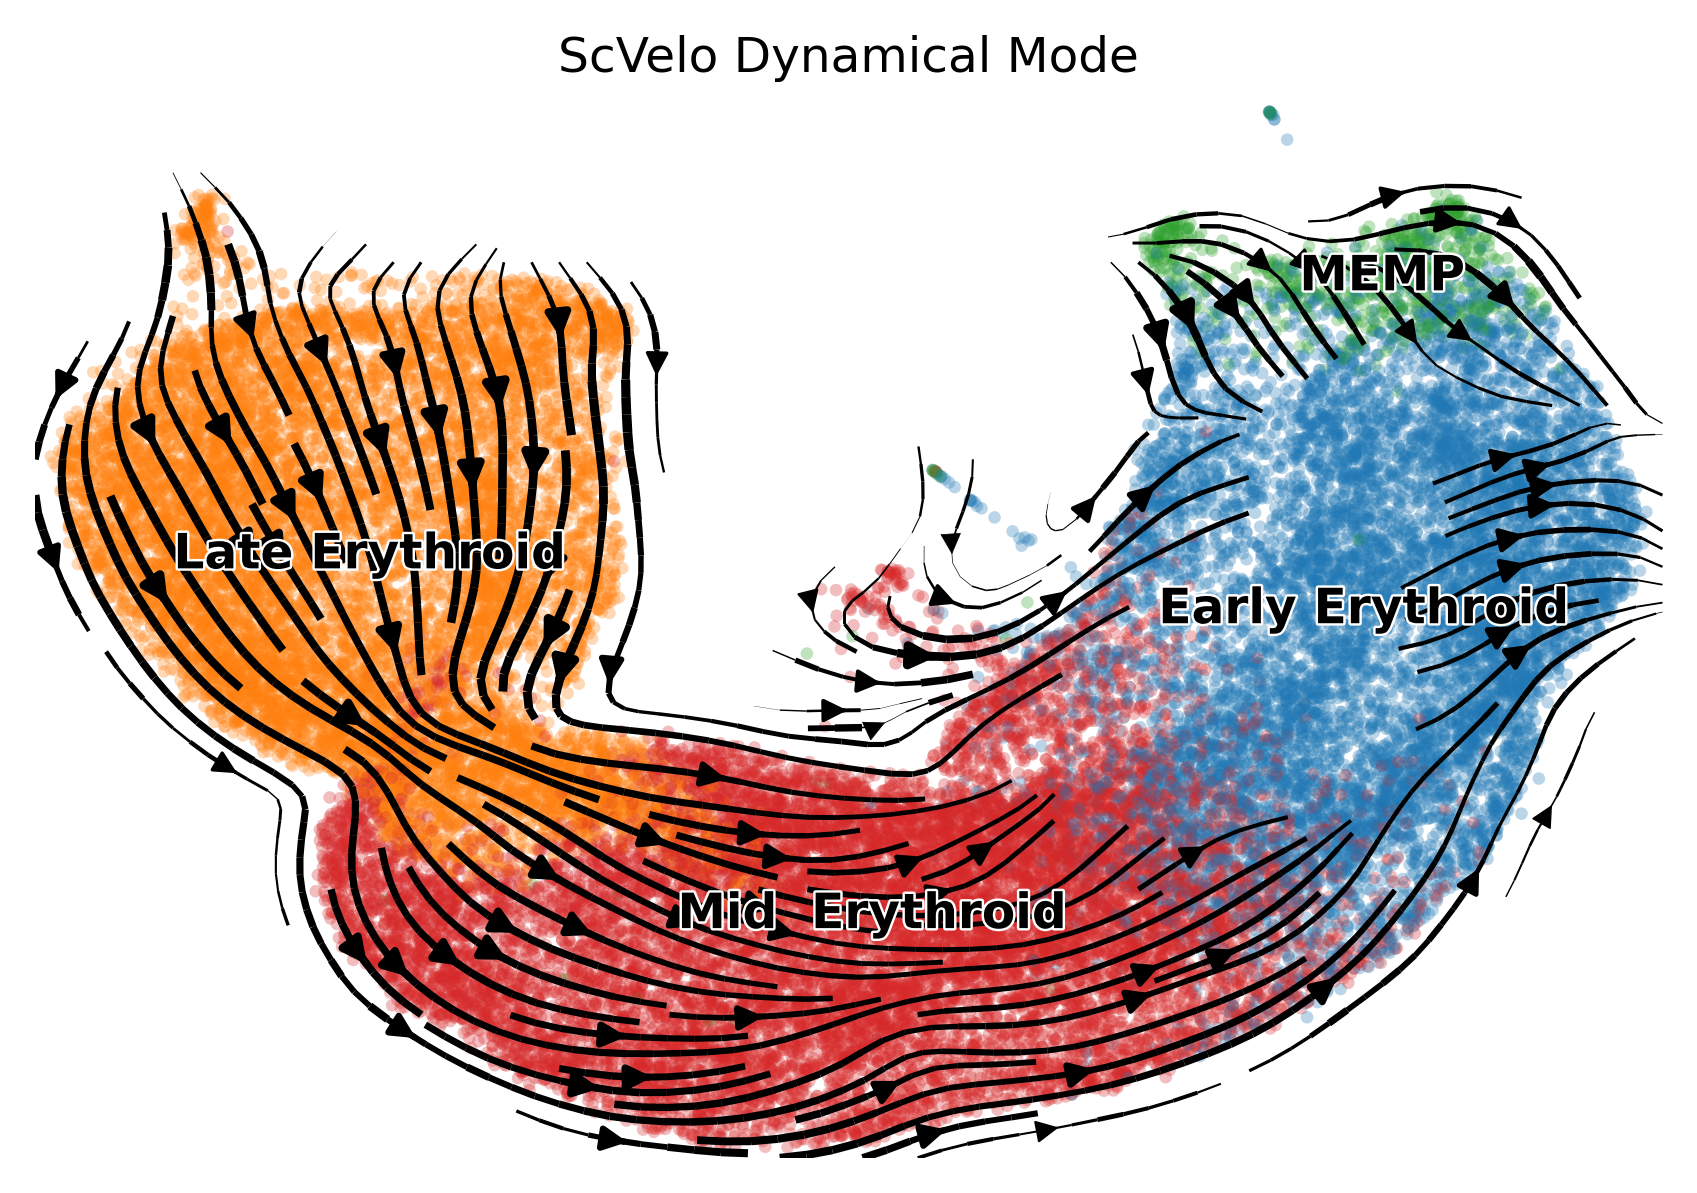

--> added 'dyn_velocity_length' (adata.obs)
--> added 'dyn_velocity_confidence' (adata.obs)
--> added 'dyn_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.11564358, ('Mid  Erythroid', 'Late Erythroid'): 0.053424194}
Total Mean: 0.08453388512134552
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.8156675570618097, ('Mid  Erythroid', 'Late Erythroid'): 0.9985974309787214}
Total Mean: 0.9071324940202656
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): -0.29562042647663705, ('Mid  Erythroid', 'Late Erythroid'): -0.711497845189614}
Total Mean: -0.5035591358331255
# In-cluster Coherence
{'Early Erythroid': 0.8302472895700661, 'Late Erythroid': 0.9769279989442082, 'MEMP': 0.9109342856238598, 'Mid  Erythroid': 0.9822736253845872}
Total Mean: 0.9250957998806804
# In-cluster Confidence
{'Early Erythroid': 0.9001440503221465, 'Late Erythroid': 0.9

In [7]:
scv.tl.recover_dynamics(adata, use_raw=False, var_names="all", n_jobs=10)
scv.tl.velocity(adata, vkey='dyn_velocity', mode='dynamical', use_raw=False)
scv.tl.velocity_graph(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="dyn_velocity", color=[k_cluster], basis='X_umap', dpi=350,
                                title='ScVelo Dynamical Mode', save="Melania_Erythroid_human_dynamical.png")
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
sel = ~np.isnan(adata.var.fit_likelihood)
exp_metrics['dyn_mode'] = evaluate(adata[:, sel], cluster_edges, k_cluster, "dyn_velocity", 'X_umap')

In [8]:
with open("dyn_Melania_Erythroid_human.pkl", 'wb') as ofile:
    pickle.dump(exp_metrics, ofile)

In [9]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

computing neighbors
    finished (0:00:35) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:11) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:09) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


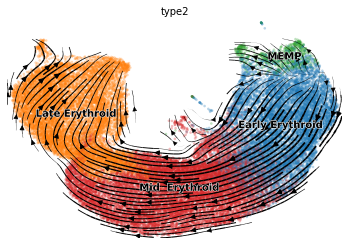

# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.65250415, ('Mid  Erythroid', 'Late Erythroid'): 0.5526629}
Total Mean: 0.6025835275650024
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.99943113, ('Mid  Erythroid', 'Late Erythroid'): 0.99927104}
Total Mean: 0.9993510842323303
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.5215688223633015, ('Mid  Erythroid', 'Late Erythroid'): 0.3447071291310593}
Total Mean: 0.4331379757471804
# In-cluster Coherence
{'Early Erythroid': 0.99950117, 'Late Erythroid': 0.99911845, 'MEMP': 0.99962306, 'Mid  Erythroid': 0.99946296}
Total Mean: 0.9994263648986816
# In-cluster Confidence
{'Early Erythroid': 0.9994815331905423, 'Late Erythroid': 0.9990936031472506, 'MEMP': 0.9994043735588122, 'Mid  Erythroid': 0.9994319120479007}
Total Mean: 0.9993528554861264


In [10]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    new_v_key = "new_velocity"
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src, new_v_key=new_v_key)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.tl.velocity_confidence(adata, vkey="new_velocity")
    scv.pl.velocity_embedding_stream(adata, vkey='new_velocity', basis='X_umap' , color=k_cluster)
    evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    return x, u, s, v
    
x, u, s, v  = exp(adata, exp_metrics)

In [11]:
sel_ery2 = adata.obs[k_cluster] == 'Mid  Erythroid'
sel_ery3 = adata.obs[k_cluster] == 'Late Erythroid'

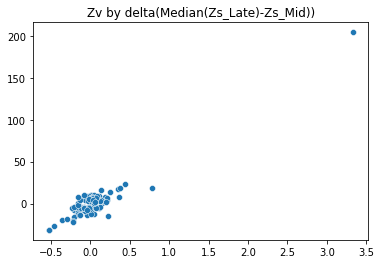

In [12]:
ax = sns.scatterplot(np.median(v[sel_ery2], axis=0), np.median(np.median(s[sel_ery3], axis=0) - s[sel_ery2], axis=0))
plt.title("Zv by delta(Median(Zs_Late)-Zs_Mid))")
ax.get_figure().savefig(f"./figures/{args.exp_name}_low_dim_v_by_delta_s.png",dpi=350)

In [13]:
import hilearn
def abline(x_vals, y_vals):
    hilearn.corr_plot(x_vals, y_vals)

(100,) (100,)
75.5% are consistent


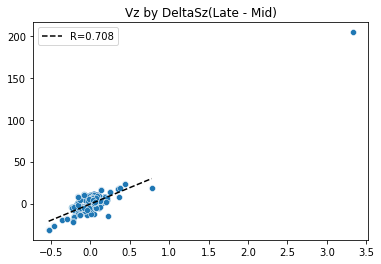

In [14]:
sel = np.ones(args.z_dim, dtype=np.bool)
median_Vu = np.median(v[sel_ery2], axis=0)
median_deltaSu = np.median(np.median(s[sel_ery3], axis=0) - s[sel_ery2], axis=0)

df = pd.DataFrame()
df['Vz'] = median_Vu
df['DeltaSz'] = median_deltaSu
df['latent_dim'] = list(range(args.z_dim))

print(median_Vu.shape, median_deltaSu.shape)
max_thred, min_thred = np.percentile(median_Vu, 99), np.percentile(median_Vu, 1)
sel = sel & (median_Vu < max_thred) & (median_Vu > min_thred)

max_thred, min_thred = np.percentile(median_deltaSu, 99), np.percentile(median_deltaSu, 1)
sel = sel & (median_deltaSu < max_thred) & (median_deltaSu > min_thred)


consist = len([1 for _v, _ds in zip(median_Vu[sel], median_deltaSu[sel]) if _v * _ds > 0])
contradict = len([1 for _v, _ds in zip(median_Vu[sel], median_deltaSu[sel]) if _v * _ds < 0])
print("{:.1%} are consistent".format(consist / (consist + contradict)))

abline(median_Vu[sel], median_deltaSu[sel])
ax = sns.scatterplot(data=df, x=median_Vu, y=median_deltaSu)

plt.title("Vz by DeltaSz(Late - Mid)")
ax.get_figure().savefig(f"./figures/{args.exp_name}_vz_by_dSz.png", dpi=350)


(2000,) (2000,)
53.2% are opposite


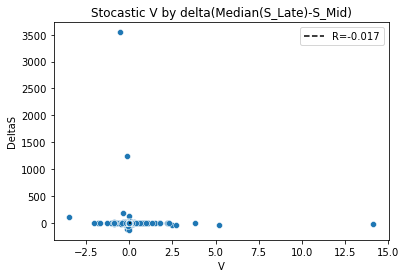

In [15]:
sel = np.ones(adata.X.shape[1], dtype=np.bool)
median_stc = np.median(adata.layers['stc_velocity'][sel_ery2], axis=0)
median_deltaS = np.median(np.median(spliced[sel_ery3], axis=0) - spliced[sel_ery2], axis=0)

print(median_stc.shape, median_deltaS.shape)
max_thred, min_thred = np.percentile(median_stc, 90), np.percentile(median_stc, 10)
sel = sel & (median_stc < max_thred) & (median_stc > min_thred)

max_thred, min_thred = np.percentile(median_deltaS, 90), np.percentile(median_deltaS, 10)
sel = sel & (median_deltaS < max_thred) & (median_deltaS > min_thred)

consist = len([1 for _v, _ds in zip(median_stc[sel], median_deltaS[sel]) if _v * _ds > 0])
contradict = len([1 for _v, _ds in zip(median_stc[sel], median_deltaS[sel]) if _v * _ds < 0])
print("{:.1%} are opposite".format(contradict /(contradict + consist)))

abline(median_stc[sel], median_deltaS[sel])

df = pd.DataFrame()
df['V'] = median_stc
df['DeltaS'] = median_deltaS

ax = sns.scatterplot(data=df, x="V", y='DeltaS')
plt.title("Stocastic V by delta(Median(S_Late)-S_Mid)")
ax.get_figure().savefig(f"./figures/{args.exp_name}_stc_v_by_delta_s_full_data.png",dpi=350)

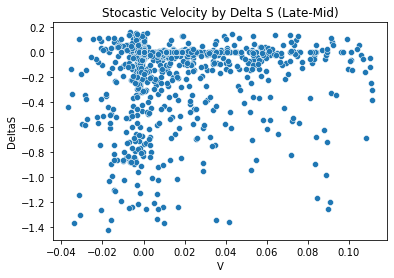

In [16]:
ax = sns.scatterplot(data=df.iloc[sel], x="V", y='DeltaS')
plt.legend([],[], frameon=False)
plt.title("Stocastic Velocity by Delta S (Late-Mid)")
ax.get_figure().savefig(f"./figures/{args.exp_name}_stc_v_by_delta_s.png",dpi=350)